 I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

 As W2.grad is 0 the gradient is killed therefore the network will not train 

In [1]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 

In [6]:
words = open("names.txt").read().splitlines()
char_list = sorted(list(set("".join(words))))

In [40]:
stoi = {s:i + 1 for i, s in enumerate(char_list)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(char_list) + 1

In [42]:
X, Y = [], []
block_size = 3

for w in words:
    context = [0] * block_size
    for ch in w + ".":
        X.append(context)
        Y.append(stoi[ch])
        context = context[1:] + [stoi[ch]]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [33]:
n1 = int(X.shape[0] * 0.8)
n2 = int(X.shape[0] * 0.9)

In [34]:
X_Train = X[:n1]
Y_Train = Y[:n1]
X_dev = X[n1:n2]
Y_dev = Y[n1:n2]
X_test = X[:n2]
Y_test = Y[:n2]

In [70]:
embed_dims = 10
n_hidden = 200

C = torch.randn(vocab_size, embed_dims) * 0
W1 = torch.randn(embed_dims * block_size, n_hidden) * 0
b1 = torch.randn(n_hidden) * 0
W2 = torch.randn(n_hidden, vocab_size) * 0
b2 = torch.randn(vocab_size) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [71]:
steps = 1
batch_size = 32
losses = []

for i in range(steps):
    batch = torch.randint(0, X_Train.shape[0], (32, ))
    Xb, Yb = X_Train[batch], Y_Train[batch]
    embeds = C[Xb].view(-1, embed_dims * block_size)
    pre_act = embeds @ W1 + b1
    h = F.tanh(pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None 
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += p.grad * -lr

    losses.append(loss.item())
    if i % 10000 == 0:
        print(i)
        print(loss)

0
tensor(3.2958, grad_fn=<NllLossBackward0>)


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0., 864.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
        -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
        -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
         0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
         0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
         0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]),
 <BarContainer object of 50 artists>)

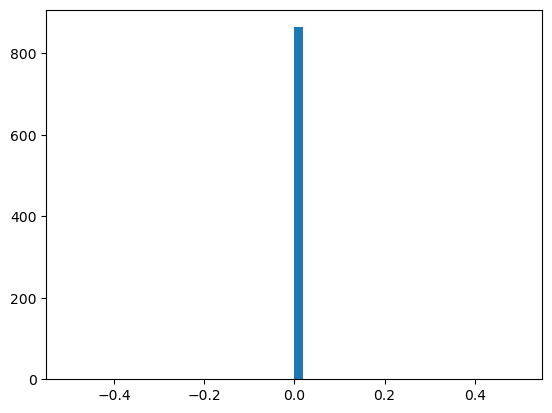

In [72]:
plt.hist(logits.view(-1).tolist(), 50)

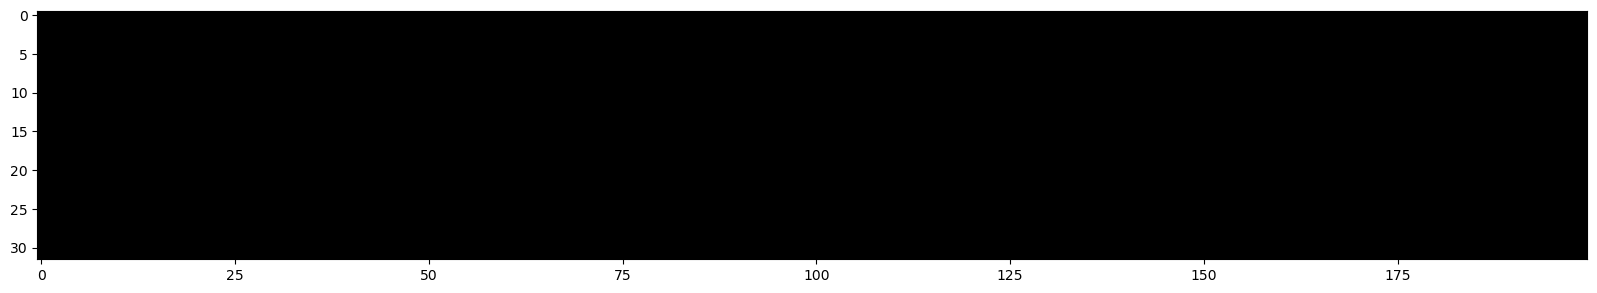

In [68]:
plt.figure(figsize=(20,20))
plt.imshow(h.abs() > 0.99, cmap="gray")

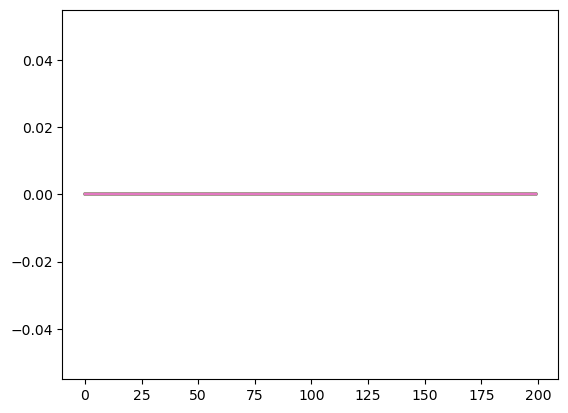

In [78]:
plt.plot(W2.grad)

 E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool

In [106]:
C = torch.randn(vocab_size ,embed_dims)
W1 = torch.randn(embed_dims * block_size, n_hidden) 
b1 = torch.randn(n_hidden) 
W2 = torch.randn(n_hidden, vocab_size) * 0.01
b2 = torch.randn(vocab_size) 

running_mean = torch.zeros(1, n_hidden)
running_std_dev = torch.zeros(1, n_hidden)

gain = torch.ones(1, n_hidden)
bias = torch.zeros(1, n_hidden)

parameters = [C, W1, b1, W2, b2, gain, bias]

for p in parameters:
    p.requires_grad = True

In [107]:
steps = 200000
batch_size = 32
losses = []

for i in range(steps):
    batch = torch.randint(0, X_Train.shape[0], (32, ))
    Xb, Yb = X_Train[batch], Y_Train[batch]
    embeds = C[Xb].view(-1, embed_dims * block_size)

    pre_act = embeds @ W1 + b1
    mean = pre_act.mean(dim = 0, keepdim=True)
    variance = pre_act.std(dim = 0, keepdim=True)

    pre_act = pre_act - mean / variance

    h = F.tanh(gain * pre_act + bias)

    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None 
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += p.grad * -lr

    running_mean = (0.999 * running_mean) + (0.001 * mean)
    running_std_dev = (0.999 * running_std_dev) +(0.001 * variance)
    
    losses.append(loss.item())
    if i % 10000 == 0:
        print(i)
        print(loss)

0
tensor(3.3925, grad_fn=<NllLossBackward0>)
10000
tensor(2.4988, grad_fn=<NllLossBackward0>)
20000
tensor(2.6370, grad_fn=<NllLossBackward0>)
30000
tensor(2.0280, grad_fn=<NllLossBackward0>)
40000
tensor(2.4729, grad_fn=<NllLossBackward0>)
50000
tensor(1.9728, grad_fn=<NllLossBackward0>)
60000
tensor(1.9318, grad_fn=<NllLossBackward0>)
70000
tensor(2.3758, grad_fn=<NllLossBackward0>)
80000
tensor(2.1597, grad_fn=<NllLossBackward0>)
90000
tensor(2.3106, grad_fn=<NllLossBackward0>)
100000
tensor(1.8843, grad_fn=<NllLossBackward0>)
110000
tensor(2.1944, grad_fn=<NllLossBackward0>)
120000
tensor(1.7866, grad_fn=<NllLossBackward0>)
130000
tensor(2.1036, grad_fn=<NllLossBackward0>)
140000
tensor(1.8195, grad_fn=<NllLossBackward0>)
150000
tensor(1.8471, grad_fn=<NllLossBackward0>)
160000
tensor(2.0214, grad_fn=<NllLossBackward0>)
170000
tensor(1.8626, grad_fn=<NllLossBackward0>)
180000
tensor(1.8344, grad_fn=<NllLossBackward0>)
190000
tensor(2.2080, grad_fn=<NllLossBackward0>)


In [98]:
b1 = b1 + bias 
W1 = W1 * gain


In [103]:
Xb, Yb = X_test, Y_test
embeds = C[Xb].view(-1, embed_dims * block_size)

pre_act = embeds @ W1 + b1
mean = pre_act.mean(dim = 0, keepdim=True)
variance = pre_act.std(dim = 0, keepdim=True)

pre_act = pre_act - mean / variance

h = F.tanh(pre_act)

logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

In [104]:
loss

tensor(2.7978, grad_fn=<NllLossBackward0>)